# Out-of-Distribution Detection for Model Refinement in Cardiac Image Segmentation

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-5a9eec5b-78cc-ab6e-3213-490f056dfd92)


In [ ]:
import random
import numpy as np
import torch

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Install requirements

#### megatools

In [ ]:
!sudo apt-get install megatools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  megatools
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 148 kB of archives.
After this operation, 1,097 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 megatools amd64 1.9.98-1build2 [148 kB]
Fetched 148 kB in 2s (65.1 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package megatools.
(Reading database ... 155219 files and directo

#### batchgenerators

In [ ]:
!pip install --upgrade batchgenerators

     |████████████████████████████████| 57 kB 2.7 MB/s 
     |████████████████████████████████| 96 kB 4.0 MB/s 
  Created wheel for batchgenerators: filename=batchgenerators-0.23-py3-none-any.whl size=84780 sha256=01a56a2499bdbb3f95c5e6b4e0ed063d553d5842bd6d7b866202e98c8b14472e
  Stored in directory: /root/.cache/pip/wheels/81/3d/a2/9a602ce56458c684d2962ec89eddd6bc06b00687735e2dd11a
Successfully built batchgenerators


#### medpy

In [ ]:
!pip install medpy

     |████████████████████████████████| 151 kB 4.0 MB/s 
     |████████████████████████████████| 48.4 MB 10 kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754483 sha256=48f770bd022f38ea6405053ad44ac8c237d66b16357ed6e7ec6c819bfa90cb24
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built medpy


#### nibabel

In [ ]:
!pip install nibabel

## Import data

In [ ]:
!git clone https://github.com/manigalati/MnMs2

Cloning into 'MnMs2'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 46 (delta 23), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (46/46), done.


In [ ]:
%cd /content/MnMs2

/content/MnMs2


In [ ]:
#!megadl "https://mega.nz/#!RERgEZhK!C9SXLaRV6Ep3pRn5ips_rGLsHUxP9wDZeJlBOSY6Af4"

!mkdir data
#MnMs2 dataset
!python gdrivedl.py https://drive.google.com/open?id=1-18mR3kwzErkqeTDZ-_UzQtalvnYK1fD data/
#vendor information
!python gdrivedl.py https://drive.google.com/open?id=1B8Rv0xGExxEahnYE7LMx0MeiJVXdaDPM data/

data/MnM-2.rar
[==================================================] 5618.07MB/5618.07MB
data/MNM2_vendor_information_training_set.csv
[==================================================] 0.00MB/0.00MB


In [ ]:
!unrar e data/MnM-2.rar data/
!rm data/MnM-2.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from data/MnM-2.rar

Extracting  data/001_LA_CINE.nii.gz                                        0%  OK 
Extracting  data/001_LA_ED.nii.gz                                          0%  OK 
Extracting  data/001_LA_ED_gt.nii.gz                                       0%  OK 
Extracting  data/001_LA_ES.nii.gz                                          0%  OK 
Extracting  data/001_LA_ES_gt.nii.gz                                       0%  OK 
Extracting  data/001_SA_CINE.nii.gz                                        0%  OK 
Extracting  data/001_SA_ED.nii.gz                                          0%  OK 
Extracting  data/001_SA_ED_gt.nii.gz                                       0%  OK 
Extracting  data/001_SA_ES.nii.gz                                          0%  OK 
Extracting  data/001_SA_ES_gt.nii.gz                                   

## Data preparation

In [ ]:
import os
from utils import get_vendor_info
from utils import get_splits
from utils import generate_patient_info, crop_image
from utils import preprocess, preprocess_image, inSplit

The challenge cohort was composed of 360 patients with different rigth ventricle and left ventricle pathologies as well as healthy subjects. All subjects were scanned in four clinical centres in two different countries (Spain, Germany) using four different magnetic resonance scanner vendors (Siemens, General Electric and Philips ).

The training set contained 200 annotated images from four different centres. The CMR images have been segmented by experienced clinicians from the respective institutions, including contours for the left (LV) and right ventricle (RV) blood pools, as well as for the left ventricular myocardium (MYO). Labels are: 1 (LV), 2 (MYO) and 3 (RV) in both short-axis and long-axis views with a variety of difficult RV pathologies and remodelling as well as LV pathologies. This year we will focus on RV segmentation. Labels 1 and 2 will be provided but will not score in the final challenge results. 40 cases, 5 for each pathology, will be used to create a public leaderboard and will be added to the final testing set. Two pathologies (Tricuspidal Regurgitation and Congenital Arrhythmogenesis) will be not present in the training set but in the validation and testing sets to evaluate generalisation to unseen pathologies.

<table style="width:70%; margin: auto">
        <tbody><tr>
            <th>Pathology</th><th>Num. studies training</th> <th>Num. studies validation</th>
        </tr>
        <tr>
            <td style="text-align:left">Normal subjects</td><td>40</td><td>5</td>
        </tr>
        <tr>
            <td style="text-align:left">Dilated Left Ventricle</td><td>30</td><td>5</td>
        </tr>
        <tr>
            <td style="text-align:left">Hypertrophic Cardiomyopathy</td><td>30</td><td>5</td>
        </tr>
        <tr>
            <td style="text-align:left">Congenital Arrhythmogenesis</td><td>20</td><td>5</td>
        </tr>
        <tr>
            <td style="text-align:left">Tetralogy of Fallot</td><td>20</td><td>5</td>
        </tr>
        <tr>      
            <td style="text-align:left">Interatrial Comunication</td><td>20</td><td>5</td>
        </tr>
        <tr>       
            <td style="text-align:left">Dilated Right Ventricle</td><td>0</td><td>5</td>
        </tr>
        <tr>
            <td style="text-align:left">Tricuspidal Regurgitation</td><td>0</td><td>5</td>
        </tr>
</tbody></table>


In [ ]:
vendor_info = get_vendor_info("data/MNM2_vendor_information_training_set.csv")
vendor_info

,SUBJECT_CODE,VENDOR,PATH
0,001_SA,GE MEDICAL SYSTEMS,data/001_SA_{}.nii.gz
1,001_LA,GE MEDICAL SYSTEMS,data/001_LA_{}.nii.gz
2,002_SA,GE MEDICAL SYSTEMS,data/002_SA_{}.nii.gz
3,002_LA,GE MEDICAL SYSTEMS,data/002_LA_{}.nii.gz
4,003_SA,GE MEDICAL SYSTEMS,data/003_SA_{}.nii.gz
...,...,...,...
395,198_LA,NaN,data/198_LA_{}.nii.gz
396,199_SA,NaN,data/199_SA_{}.nii.gz
397,199_LA,NaN,data/199_LA_{}.nii.gz
398,200_SA,NaN,data/200_SA_{}.nii.gz


In [ ]:
vendor_info[['VENDOR','SUBJECT_CODE']].groupby(['VENDOR']).count().rename(columns={'SUBJECT_CODE':'NUM_STUDIES'})

,NUM_STUDIES
VENDOR,
GE MEDICAL SYSTEMS,52
Philips Medical Systems,128
SIEMENS,140


In [ ]:
if not os.path.isdir("preprocessed"):
    os.makedirs("preprocessed")
splits = get_splits(os.path.join("preprocessed", "splits.pkl"))

In [ ]:
patient_info = generate_patient_info(vendor_info, os.path.join("preprocessed", "patient_info.pkl"))

In [ ]:
spacings = [
    patient_info["{:03d}_{}".format(id, axis)]["spacing"] for axis in ["SA", "LA"] for id in (
        splits["train"]["lab"] + splits["train"]["ulab"] + splits["val"]
    )
]
spacing_target = np.percentile(np.vstack(spacings), 50, 0)

if not os.path.isdir("preprocessed/training/labelled"): os.makedirs("preprocessed/training/labelled")
if not os.path.isdir("preprocessed/training/unlabelled"): os.makedirs("preprocessed/training/unlabelled")
if not os.path.isdir("preprocessed/validation/"): os.makedirs("preprocessed/validation/")
if not os.path.isdir("preprocessed/soft_validation/"): os.makedirs("preprocessed/soft_validation/")
if not os.path.isdir("preprocessed/testing/"): os.makedirs("preprocessed/testing/")

preprocess(
    {k:v for k,v in patient_info.items() if inSplit(k, splits["train"]["lab"])},
    spacing_target, "preprocessed/training/labelled/"
)
preprocess(
    {k:v for k,v in patient_info.items() if inSplit(k, splits["train"]["ulab"])},
    spacing_target, "preprocessed/training/unlabelled/"
)
preprocess(
    {k:v for k,v in patient_info.items() if inSplit(k, splits["val"])},
    spacing_target, "preprocessed/validation/"
)
preprocess(
    {k:v for k,v in patient_info.items() if inSplit(k, splits["val"])},
    spacing_target, "preprocessed/soft_validation/", soft_preprocessing=True
)
preprocess(
    {k:v for k,v in patient_info.items() if inSplit(k, splits["test"])},
    spacing_target, "preprocessed/testing/", soft_preprocessing=True
)

## $\mathcal{M}$ - Supervised Training

In [ ]:
import torch.nn as nn
import os
import torch

from baseline_1 import Baseline_1
from baseline_2 import Baseline_2
from utils import AttrDict
from utils import GDLoss, CELoss
from utils import device
from utils import Validator, Checkpointer
from utils import supervised_training
from utils import ACDCDataLoader, ACDCAllPatients
from utils import BATCH_SIZE, EPOCHS, CKPT
from utils import transform_augmentation_downsample, transform
from utils import plot_history

In [ ]:
Model = Baseline_2

model = nn.ModuleDict([
    [axis, Model(
        AttrDict(**{
            "lr": 0.01,
            "functions": [GDLoss, CELoss]
        })
    )] for axis in ["SA", "LA"]
]).to(device)

ckpts = None
if ckpts is not None:
    for axis, ckpt in ckpts.items():
        _, start = os.path.split(ckpt)
        start = int(start.replace(".pth", ""))
        ckpt = torch.load(ckpt)
        model[axis].load_state_dict(ckpt["M"])
        model[axis].optimizer.load_state_dict(ckpt["M_optim"])
else:
    start = 1
print(model)

ModuleDict(
  (SA): Baseline_2(
    (unet): Generic_UNet(
      (conv_blocks_localization): ModuleList(
        (0): Sequential(
          (0): StackedConvLayers(
            (blocks): Sequential(
              (0): ConvDropoutNormNonlin(
                (conv): Conv2d(960, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (instnorm): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
              )
            )
          )
          (1): StackedConvLayers(
            (blocks): Sequential(
              (0): ConvDropoutNormNonlin(
                (conv): Conv2d(480, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (instnorm): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
              )
            )
          )
        )
        (1): Se

Epoch [init]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.012	2.0036	1.9916	0.0044	165.92	0.0178	161.33	0.0058	186.13	
Epoch [1]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.071	0.1598	0.0883	0.0001	inf	0.0000	inf	0.0003	inf	
Epoch [2]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.333	0.0751	-0.258	0.5628	38.430	0.5209	36.411	0.0000	inf	
Epoch [3]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.345	0.2779	-0.067	0.4959	61.444	0.3092	67.803	0.2477	112.46	
Epoch [4]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.724	0.0642	-0.660	0.8374	45.666	0.7049	51.418	0.6718	71.852	
Epoch [5]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.755	0.0558	-0.699	0.8429	39.540	0.7033	47.123	0.7617	43.192	
Epoch [6]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.762	0.0475	-0.715	0.8591	10.353	0.7155	12.884	0.7550	21.649	
Epoch [7]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.788	0.

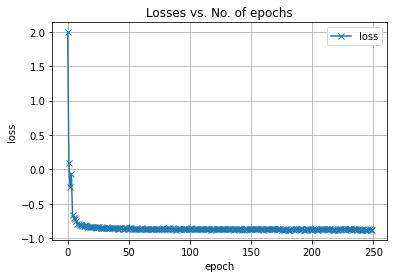

Epoch [init]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.051	2.7348	2.6837	0.1230	182.75	0.0004	139.35	0.0278	198.05	
Epoch [1]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.058	0.7081	0.6499	0.1971	170.68	0.0053	156.02	0.0392	173.13	
Epoch [2]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.073	0.2993	0.2254	0.0001	inf	0.0000	inf	0.0012	inf	
Epoch [3]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.085	0.3208	0.2350	0.0000	inf	0.0000	inf	0.0000	inf	
Epoch [4]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.084	0.3410	0.2565	0.0013	inf	0.0000	inf	0.0000	inf	
Epoch [5]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.089	0.3420	0.2528	0.0052	inf	0.0000	inf	0.0000	inf	
Epoch [6]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.100	0.3238	0.2231	0.0017	inf	0.0000	inf	0.0000	inf	
Epoch [7]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.100	0.2930	0.1927	0.0000	inf	0.0000	inf

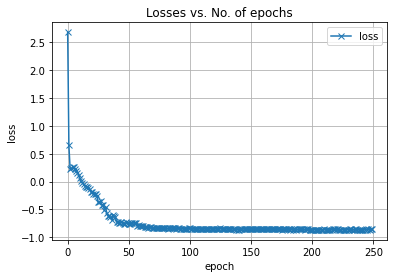

In [ ]:
validators = {
    "SA": Validator(5),
    "LA": Validator(5)
}

for axis in ["SA", "LA"]:
    supervised_training(
        model[axis],
        range(start, EPOCHS),
        torch.utils.data.DataLoader(
            ACDCAllPatients(
                os.path.join("preprocessed/training/labelled/", axis),
                transform=transform_augmentation_downsample
            ),
            batch_size=BATCH_SIZE, shuffle=False, num_workers=0
        ),
        ACDCDataLoader(
            os.path.join("preprocessed/validation/", axis),
            batch_size=BATCH_SIZE, transform=transform
        ),
        validators[axis],
        Checkpointer(os.path.join(CKPT, "M", axis))
    )

    plot_history(validators[axis].get_history("val"))

## $\mathcal{M}$ - Testing

In [ ]:
import torch.nn as nn
import os
import torch
import pickle
import numpy as np
import pandas as pd

from baseline_1 import Baseline_1
from baseline_2 import Baseline_2
from utils import device
from utils import ACDCDataLoader
from utils import BATCH_SIZE, CKPT
from utils import transform
from utils import infer_predictions
from utils import get_splits
from utils import postprocess_predictions, display_results

In [ ]:
Model = Baseline_2

model = nn.ModuleDict([
    [axis, Model()] for axis in ["SA", "LA"]
]).to(device)

for axis in ["SA", "LA"]:
    ckpt = os.path.join(CKPT, "M", axis, "best_000.pth")
    model[axis].load_state_dict(torch.load(ckpt)["M"])
    model[axis].to(device)
    model.eval()

    infer_predictions(
        os.path.join("inference", axis),
        ACDCDataLoader(
            f"preprocessed/testing/{axis}",
            batch_size = BATCH_SIZE,
            transform = transform,
            transform_gt = False
        ),
        model[axis]
    )

In [ ]:
splits = get_splits(os.path.join(CKPT, "splits.pkl"))

with open(os.path.join("preprocessed", "patient_info.pkl"),'rb') as f:
    patient_info = pickle.load(f)

spacings = [
    patient_info["{:03d}_{}".format(id, axis)]["spacing"] for axis in ["SA", "LA"] for id in (
        splits["train"]["lab"] + splits["train"]["ulab"] + splits["val"]
    )
]

current_spacing = np.percentile(np.vstack(spacings), 50, 0)

In [ ]:
results = {}
for axis in ["SA", "LA"]:
    results[axis] = postprocess_predictions(
        os.path.join("inference", axis),
        patient_info,
        current_spacing,
        os.path.join("postprocessed", axis),
    )

with open("postprocessed/results.pkl", "wb") as f:
    pickle.dump(results,f)

display_results(results)

,RV_ED_DC,RV_ED_HD,RV_ES_DC,RV_ES_HD,RV_DC,RV_HD
axis,,,,,,
SA,NaN,NaN,NaN,NaN,NaN,NaN
LA,NaN,NaN,NaN,NaN,NaN,NaN


Here we test our model on the testing set provided in the M&Ms-2 Challenge. For this reason, no GT is available, and validation metrics cannot be directly evaluated (this is why all values in the table above are NaN). The code in the cells below display the results reported in the <a href="https://www.ub.edu/mnms-2/#:~:text=the%20competition%20in-,Codalab,-to%20submit%20your"> Codalab platform</a>.

In [ ]:
for axis in ["SA", "LA"]:
    for src in os.listdir(os.path.join("postprocessed", axis)):
        id = src.split("_")[0]
        if int(id) < 161:
            continue
        nib_image = nib.load(os.path.join("postprocessed", axis, src))
        image = np.around(nib_image.get_fdata()).astype(int)
        image = np.where(image==3, 1, 0)
        dst = os.path.join("submission", id, src.split(".nii.gz")[0] + "_pred.nii.gz")
        if not os.path.isdir(os.path.split(dst)[0]):
            os.makedirs(os.path.split(dst)[0])
        nib.save(nib.Nifti1Image(image, nib_image.affine, nib_image.header), dst)

In [ ]:
!zip -rq submission.zip submission

In [8]:
print("\033[1mBaseline\033[0m")
pd.DataFrame.from_dict({
    "axis": ["SA", "LA", "avg"],
    "RV_DC": [0.903681832739, 0.899725671050, 0.902692792316],
    "RV_HD": [13.350667610394, 7.404528745594, 11.864132894194],
}).set_index("axis")

Baseline


,RV_DC,RV_HD
axis,,
SA,0.903682,13.350668
LA,0.899726,7.404529
avg,0.902693,11.864133


## $\mathcal{R}$ - Training

In [ ]:
import torch.nn as nn
import torch
import os

from reconstructor import Reconstructor
from utils import AttrDict
from utils import device
from utils import plot_history
from utils import ACDCAllPatients, ACDCDataLoader
from utils import transform
from utils import BATCH_SIZE, CKPT

In [ ]:
ae = nn.ModuleDict([
    [axis, Reconstructor(
        AttrDict(**{
            "latent_size": 100,
            "lr": 2e-4,
            "last_layer": [4,2,1],
            "in_channels": 4,
            "weighted_epochs": 0
        })
    )] for axis in ["SA", "LA"]
]).to(device)

ckpts = None
if ckpts is not None:
    for axis, ckpt in ckpts.items():
        _, start = os.path.split(ckpt)
        start = int(start.replace(".pth", ""))
        ckpt = torch.load(ckpt)
        ae[axis].load_state_dict(ckpt["R"])
        ae[axis].optimizer.load_state_dict(ckpt["R_optim"])
else:
    start = 0
print(ae)

ModuleDict(
  (SA): Reconstructor(
    (encoder): Sequential(
      (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.2)
      (7): Dropout(p=0.5, inplace=False)
      (8): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2)
      (11): Dropout(p=0.5, inplace=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): Leaky

Epoch [0]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0228	-0.014	0.0082	0.0000	inf	0.0000	inf	0.0000	inf	
Epoch [1]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0148	-0.009	0.0052	0.0000	inf	0.0000	inf	0.0000	inf	
Epoch [2]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0091	-0.244	-0.235	0.4965	20.029	0.2463	18.207	0.4680	23.334	
Epoch [3]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0082	-0.375	-0.367	0.5931	16.561	0.2616	13.476	0.6128	17.677	
Epoch [4]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0076	-0.413	-0.406	0.6056	15.406	0.2806	11.804	0.6602	15.722	
Epoch [5]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0075	-0.448	-0.440	0.7111	14.290	0.2926	20.605	0.6246	16.968	
Epoch [6]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0071	-0.493	-0.486	0.7479	11.124	0.4170	18.179	0.6311	16.384	
Epoch [7]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0075	-0.499	-0.4

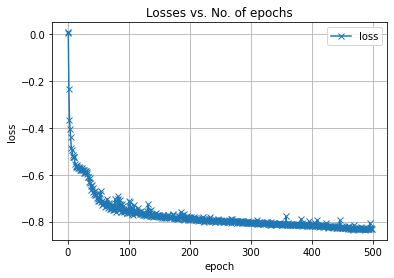

Epoch [0]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.1803	-0.042	0.1376	0.0173	179.16	0.0306	181.34	0.0360	197.18	
Epoch [1]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.1521	-0.042	0.1100	0.0000	inf	0.0179	181.25	0.0374	197.46	
Epoch [2]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.1252	-0.041	0.0839	0.0000	inf	0.0000	181.25	0.0366	197.46	
Epoch [3]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.1042	-0.040	0.0639	0.0000	inf	0.0000	185.99	0.0000	194.53	
Epoch [4]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0859	-0.039	0.0468	0.0000	inf	0.0000	185.99	0.0000	inf	
Epoch [5]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0713	-0.037	0.0336	0.0000	inf	0.0000	185.99	0.0000	inf	
Epoch [6]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0613	-0.036	0.0250	0.0000	inf	0.0000	inf	0.0000	inf	
Epoch [7]
MSELos	GDLoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
0.0532	-0.034	0.0185	0.0000	in

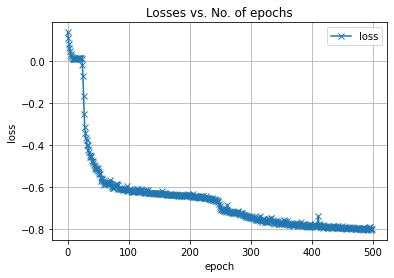

In [ ]:
for axis in ["SA", "LA"]:
    plot_history(ae[axis].training_routine(
        range(start, 500),
        torch.utils.data.DataLoader(
            ACDCAllPatients(
                os.path.join("preprocessed/training/labelled/", axis),
                transform=transform
            ),
            batch_size=BATCH_SIZE, shuffle=False, num_workers=0
        ),
        ACDCDataLoader(
            os.path.join("preprocessed/validation/", axis),
            batch_size=BATCH_SIZE, transform=transform
        ),
        os.path.join(CKPT, "R", axis)
    ))

## QC-based Candidate Selection

In [ ]:
import torch.nn as nn
import os
import torch
import pickle
import numpy as np

from baseline_1 import Baseline_1
from baseline_2 import Baseline_2
from reconstructor import Reconstructor
from utils import device
from utils import AttrDict
from utils import Validator
from utils import ACDCDataLoader
from utils import BATCH_SIZE, CKPT
from utils import transform
from utils import GDLoss, CELoss, GDLoss_RV, CELoss_RV
from utils import infer_predictions
from utils import get_splits
from utils import postprocess_predictions
from utils import display_results

In [ ]:
Model = Baseline_2

model = nn.ModuleDict([
    [axis, Model(
        AttrDict(**{
            "lr": 0.01,

            "functions": [GDLoss, CELoss],
            "functions_RV": [GDLoss_RV, CELoss_RV]
        })
    )] for axis in ["SA", "LA"]
]).to(device)

ae = nn.ModuleDict([
    [axis, Reconstructor(
        AttrDict(**{
            "latent_size": 100,
            "lr": 2e-4,
            "last_layer": [4,2,1],
            "in_channels": 4,
            "weighted_epochs": 0
        })
    )] for axis in ["SA", "LA"]
]).to(device)

validators = {
    "SA": Validator(5),
    "LA": Validator(5)
}

for axis in ["SA", "LA"]:
    ckpt = os.path.join(CKPT, "R", axis)
    ckpt = os.path.join(ckpt, sorted([file for file in os.listdir(ckpt) if "_best" in file])[-1])
    ckpt = torch.load(ckpt)
    ae[axis].load_state_dict(ckpt["R"])
    ae.eval()
    
    ckpt = os.path.join(CKPT, "M_refinement")
    if not os.path.isdir(ckpt):
        ckpt = os.path.join(CKPT, "M")
    for file in os.listdir(os.path.join(ckpt, axis)):
        if "best_" not in file or not file.endswith(".pth"):
            continue
        model[axis].load_state_dict(torch.load(os.path.join(ckpt, axis, file))["M"])
        model.eval()
        with torch.no_grad():
            validators[axis].domain_evaluation(
                "test",
                model[axis],
                ACDCDataLoader(
                    f"preprocessed/testing/{axis}",
                    batch_size=BATCH_SIZE,
                    transform=transform,
                    transform_gt=False
                ),    
                reconstructor=ae[axis]
            )


In [ ]:
for axis in ["SA", "LA"]:
    infer_predictions(
        os.path.join("inference", axis),
        ACDCDataLoader(
            f"preprocessed/testing/{axis}",
            batch_size=BATCH_SIZE,
            transform=transform,
            transform_gt=False
        ),
        validator=validators[axis]
    )

In [ ]:
splits = get_splits(os.path.join(CKPT, "splits.pkl"))

with open(os.path.join("preprocessed", "patient_info.pkl"),'rb') as f:
    patient_info = pickle.load(f)

spacings = [
    patient_info["{:03d}_{}".format(id, axis)]["spacing"] for axis in ["SA", "LA"] for id in (
        splits["train"]["lab"] + splits["train"]["ulab"] + splits["val"]
    )
]

current_spacing = np.percentile(np.vstack(spacings), 50, 0)

In [ ]:
results = {}
for axis in ["SA", "LA"]:
    results[axis] = postprocess_predictions(
        os.path.join("inference", axis),
        patient_info,
        current_spacing,
        os.path.join("postprocessed", axis),
    )

with open("postprocessed/results.pkl", "wb") as f:
    pickle.dump(results,f)

display_results(results)

,RV_ED_DC,RV_ED_HD,RV_ES_DC,RV_ES_HD,RV_DC,RV_HD
axis,,,,,,
SA,NaN,NaN,NaN,NaN,NaN,NaN
LA,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for axis in ["SA", "LA"]:
    for src in os.listdir(os.path.join("postprocessed", axis)):
        id = src.split("_")[0]
        if int(id) < 161:
            continue
        nib_image = nib.load(os.path.join("postprocessed", axis, src))
        image = np.around(nib_image.get_fdata()).astype(int)
        image = np.where(image==3, 1, 0)
        dst = os.path.join("submission", id, src.split(".nii.gz")[0] + "_pred.nii.gz")
        if not os.path.isdir(os.path.split(dst)[0]):
            os.makedirs(os.path.split(dst)[0])
        nib.save(nib.Nifti1Image(image, nib_image.affine, nib_image.header), dst)

In [ ]:
!zip -rq submission.zip submission

We display below the results reported in the <a href="https://www.ub.edu/mnms-2/#:~:text=the%20competition%20in-,Codalab,-to%20submit%20your"> Codalab platform</a> after submitting the .zip file generated above.

In [9]:
print("\033[1mQC-based Candidate Selection\033[0m")
pd.DataFrame.from_dict({
    "axis": ["SA", "LA", "avg"],
    "RV_DC": [0.898024197115, 0.904328292327, 0.899600220918],
    "RV_HD": [12.194214048970, 7.522092252961, 11.026183599968],
}).set_index("axis")

QC-based Candidate Selection


,RV_DC,RV_HD
axis,,
SA,0.898024,12.194214
LA,0.904328,7.522092
avg,0.899600,11.026184


## Semi-Supervised Refinement

In [ ]:
import torch.nn as nn
import os
import torch
import pickle

from baseline_1 import Baseline_1
from baseline_2 import Baseline_2
from reconstructor import Reconstructor
from utils import AttrDict
from utils import GDLoss, CELoss, GDLoss_RV, CELoss_RV
from utils import device
from utils import Validator, Checkpointer
from utils import semisupervised_refinement
from utils import ACDCDataLoader, ACDCAllPatients
from utils import BATCH_SIZE, EPOCHS, CKPT
from utils import transform_augmentation_downsample, transform
from utils import plot_history

In [ ]:
Model = Baseline_2

model = nn.ModuleDict([
    [axis, Model(
        AttrDict(**{
            "lr": 0.01,
            "functions": [GDLoss, CELoss],
            "functions_RV": [GDLoss_RV, CELoss_RV]
        })
    )] for axis in ["SA", "LA"]
]).to(device)

ae = nn.ModuleDict([
    [axis, Reconstructor(
        AttrDict(**{
            "latent_size": 100,
            "lr": 2e-4,
            "last_layer": [4,2,1],
            "in_channels": 4,
            "weighted_epochs": 0
        })
    )] for axis in ["SA", "LA"]
]).to(device)

validators = {
    "SA": Validator(5),
    "LA": Validator(5)
}

for axis in ["SA", "LA"]:
    ckpt = os.path.join(CKPT, "R", axis)
    ckpt = os.path.join(ckpt, sorted([file for file in os.listdir(ckpt) if "_best" in file])[-1])
    ckpt = torch.load(ckpt)
    ae[axis].load_state_dict(ckpt["R"])
    ae.eval()

    ckpt = os.path.join(CKPT, "M", axis, "200.pth")
    _, start = os.path.split(ckpt)
    start = int(start.replace(".pth", ""))
    ckpt = torch.load(ckpt)
    model[axis].load_state_dict(ckpt["M"])
    model[axis].optimizer.load_state_dict(ckpt["M_optim"])

    ckpt = os.path.join(CKPT, "M", axis, "200_val.pkl")
    with open(ckpt, "rb") as f:
        validators[axis] = pickle.load(f)

print(model)

ModuleDict(
  (SA): Baseline_2(
    (unet): Generic_UNet(
      (conv_blocks_localization): ModuleList(
        (0): Sequential(
          (0): StackedConvLayers(
            (blocks): Sequential(
              (0): ConvDropoutNormNonlin(
                (conv): Conv2d(960, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (instnorm): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
              )
            )
          )
          (1): StackedConvLayers(
            (blocks): Sequential(
              (0): ConvDropoutNormNonlin(
                (conv): Conv2d(480, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (instnorm): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
              )
            )
          )
        )
        (1): Se

Epoch [init]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.895	0.0213	-0.873	0.9336	4.6446	0.8499	7.2070	0.9144	6.8818	
Epoch [200 - supervised training]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.891	0.0230	-0.868	0.9328	5.5753	0.8543	8.6784	0.9014	9.1691	6.0000	
Epoch [200 - semisupervised refinement]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.890	0.0243	-0.865	0.9326	5.4394	0.8528	8.7443	0.8975	10.633	6.0000	
Epoch [201 - supervised training]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.888	0.0239	-0.864	0.9289	4.8569	0.8483	7.1047	0.9011	16.859	6.0000	
Epoch [201 - semisupervised refinement]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.883	0.0256	-0.857	0.9249	4.8622	0.8430	7.4481	0.8953	11.528	7.0000	
Epoch [202 - supervised training]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.885	0.0242	-0.861	0.9309	3.8852	0.8379	7.5654	0.9034	9.0367	7.0000	
Ep

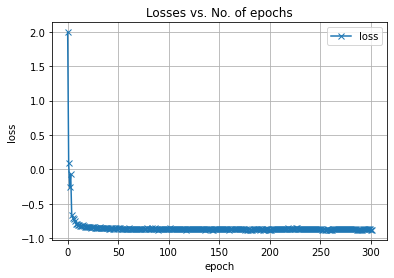

Epoch [init]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	
-0.897	0.0335	-0.864	0.9499	4.4769	0.8579	5.7341	0.9060	7.1181	
Epoch [200 - supervised training]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.899	0.0328	-0.867	0.9496	4.3734	0.8596	7.3384	0.9102	6.3261	5.0000	
Epoch [200 - semisupervised refinement]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.869	0.0477	-0.821	0.9420	6.9328	0.8364	9.0244	0.8512	7.4267	9.0000	
Epoch [201 - supervised training]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.873	0.0458	-0.827	0.9367	14.623	0.8237	12.923	0.8798	8.9192	5.0000	
Epoch [201 - semisupervised refinement]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.850	0.0634	-0.787	0.9185	15.187	0.8026	9.2855	0.8550	11.680	4.0000	
Epoch [202 - supervised training]
GDLoss	CELoss	Total	LV_dc	LV_hd	MYO_dc	MYO_hd	RV_dc	RV_hd	#anom	
-0.785	0.0883	-0.697	0.9026	19.384	0.7483	32.676	0.7311	inf	5.0000	
Epoch

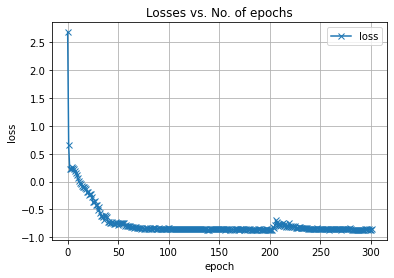

In [ ]:
for axis in ["SA", "LA"]:
    semisupervised_refinement(
        model[axis],
        ae[axis],
        range(start, EPOCHS),
        torch.utils.data.DataLoader(
            ACDCAllPatients(
                os.path.join("preprocessed/training/labelled/", axis),
                transform=transform_augmentation_downsample
            ),
            batch_size=BATCH_SIZE, shuffle=False, num_workers=0
        ),
        ACDCDataLoader(
            os.path.join("preprocessed/validation/", axis),
            batch_size=BATCH_SIZE, transform=transform
        ),
        ACDCDataLoader(
            os.path.join("preprocessed/training/unlabelled/", axis),
            batch_size = BATCH_SIZE, transform=transform
        ),
        validators[axis],
        Checkpointer(os.path.join(CKPT, "M_refinement", axis))
    )

    plot_history(validators[axis].get_history("val"))

After semi-supervised refinement, go back to QC-based Candidate Selection to validate your model. We report below the results from the <a href="https://www.ub.edu/mnms-2/#:~:text=the%20competition%20in-,Codalab,-to%20submit%20your"> Codalab platform</a>.

In [10]:
print("\033[1mSemi-Supervised Refinement\033[0m")
pd.DataFrame.from_dict({
    "axis": ["SA", "LA", "avg"],
    "RV_DC": [0.900794533587, 0.899223080762, 0.900401670381],
    "RV_HD": [12.268410479696, 7.016155479374, 10.955346729616],
}).set_index("axis")

Semi-Supervised Refinement


,RV_DC,RV_HD
axis,,
SA,0.900795,12.268410
LA,0.899223,7.016155
avg,0.900402,10.955347
